In [1]:
#import packages - not going to use all of them but just in case
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sn
from  plotnine import *
import ggplot

C:\Users\drew.malter\AppData\Local\Continuum\anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


In [2]:
#import packages
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sn
from  plotnine import *
import ggplot
from ggplot import *
import io
import re as re
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import xlsxwriter
from pandas import ExcelWriter
import matplotlib.pyplot as plt
pd.options.display.max_columns = 100
import datetime
import os

In [3]:
#read in data and parse dates, adjust other data types 
os.chdir('C:/Users/drew.malter/Documents/Internal/Personal/NFL')
df = pd.read_csv('pbp-2016-18.csv', parse_dates = ['GameDate'])

In [4]:
#Look at the data
df.head(3)

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Unnamed: 10,SeriesFirstDown,Unnamed: 12,NextScore,Description,TeamWin,Unnamed: 16,Unnamed: 17,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards
0,2018090600,2018-09-06,1,15,0,PHI,ATL,0,0,35,nan,1,nan,0,4-J.ELLIOTT KICKS 65 YARDS FROM PHI 35 TO END ...,0,nan,nan,2018,0,UNDER CENTER,KICK OFF,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,35,OWN,0,NaN,0,NaN,0
1,2018090600,2018-09-06,1,15,0,ATL,PHI,1,10,25,nan,0,nan,0,"(15:00) PENALTY ON ATL-82-L.PAULSEN, FALSE STA...",0,nan,nan,2018,0,UNDER CENTER,NO PLAY,0,0,0,0,NaN,0,0,0,nan,0,0,0,1,0,0,NaN,25,OWN,1,ATL,1,FALSE START,5
2,2018090600,2018-09-06,1,15,0,ATL,PHI,1,15,20,nan,0,nan,0,(15:00) 2-M.RYAN PASS SHORT RIGHT TO 11-J.JONE...,0,nan,nan,2018,10,UNDER CENTER,PASS,0,1,0,0,SHORT RIGHT,0,0,0,nan,0,0,0,0,0,0,NaN,20,OWN,0,NaN,0,NaN,0


In [5]:
df.shape

(136260, 45)

In [6]:
# Remove plays where yardline = 0
#These are two minute warnings, time outs, extra points, , etc. and we wont use them
#However we need to keep kick offs because they'll help us define the first possession of every half
#If down is 0 and yarline is 35 then we keep it. 
df = df[(df.Down != 0) | ((df.Down == 0) & (df.YardLine == 35))]
df.shape

(121887, 45)

In [7]:
#Sort data by gameID, quarter, minute, second, down (Minute and Second sort large to small)
df = df.sort_values(['GameId', 'Quarter', 'Minute', 'Second', 'Down'], ascending=[False, True, False, False, True]).reset_index()
df.head(3)

,index,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Unnamed: 10,SeriesFirstDown,Unnamed: 12,NextScore,Description,TeamWin,Unnamed: 16,Unnamed: 17,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards
0,44840,2018123015,2018-12-30,1,15,0,SEA,ARI,0,0,35,nan,1,nan,0,11-S.JANIKOWSKI KICKS 65 YARDS FROM SEA 35 TO ...,0,nan,nan,2018,0,UNDER CENTER,KICK OFF,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,35,OWN,0,NaN,0,NaN,0
1,44841,2018123015,2018-12-30,1,15,0,ARI,SEA,1,10,25,nan,0,nan,0,(15:00) 3-J.ROSEN PASS INCOMPLETE DEEP RIGHT T...,0,nan,nan,2018,0,UNDER CENTER,PASS,0,1,1,0,DEEP RIGHT,0,0,0,nan,0,0,0,0,0,0,NaN,25,OWN,0,NaN,0,NaN,0
2,44842,2018123015,2018-12-30,1,14,53,ARI,SEA,2,10,25,nan,0,nan,0,(14:53) (SHOTGUN) 31-D.JOHNSON LEFT TACKLE TO ...,0,nan,nan,2018,9,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,LEFT TACKLE,25,OWN,0,NaN,0,NaN,0


In [8]:
#Create a flag for if a play is a successful onside kick.  This is the only instance where a possession starts
#despite the offensive team being the same for back to back rows
#Onside Kick Success if description contains ONSIDE and RECOVERED BY

##Deciding not to use Onside Kicks because the following possessions are anomaly game situations
df['IsOnsideSuccess'] = np.where(df['Description'].str.contains('ONSIDE&RECOVERED BY', case=False, na=False), 1, 0)

In [9]:
#Create LagGameId, LagDefenseTeam, LagQuarter in order to compare to respective columns to find start of possessions
df['LagGameId'] = df['GameId'].shift(1)
df['LagDefenseTeam'] = df['DefenseTeam'].shift(1)

In [10]:
#Create IsStartOfPossession where GameId = LagGameId, DefenseTeam != LagDefenseTeam (Every time def team switches in game)
#Also flag a play if it's quarter = 1 or 3 and minute = 15 second = 0
df['IsStartOfPossession'] = np.where((df['GameId'] == df['LagGameId']) & (df['DefenseTeam'] != df['LagDefenseTeam']), 1, 0)

In [11]:
#We are still including instances where a team kicks off the 2nd half after finishing the 1st half on Def as a start of pos
#Revalue those from 1 to 0 here:

df.loc[(df.YardLine == 35) & (df.Down == 0), 'IsStartOfPossession'] = 0

In [12]:
#Create flag for the 4 types of scores

#Offensive TD if TD and no interception nor fumble
#Defensive TD if TD and interception or fumble
#Safety if description contains 'Safety'
#Field Goal if description contains 'Field Goal is Good'

df['IsOffensiveTD'] = np.where((df['IsTouchdown'] == 1) & (df['IsInterception'] == 0) & (df['IsFumble'] == 0), 1, 0)
df['IsDefensiveTD'] = np.where((df['IsTouchdown'] == 1) & ((df['IsInterception'] == 1) | (df['IsFumble'] == 1)), 1, 0)  
df['IsFieldGoal'] = np.where(df['Description'].str.contains('Field Goal is Good', case=False, na=False), 1, 0) 
df['IsSafety'] = np.where(df['Description'].str.contains('Safety', case=False, na=False), 1, 0) 

In [13]:
#See what the data set looks like at this point
df.head()

,index,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Unnamed: 10,SeriesFirstDown,Unnamed: 12,NextScore,Description,TeamWin,Unnamed: 16,Unnamed: 17,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,IsOnsideSuccess,LagGameId,LagDefenseTeam,IsStartOfPossession,IsOffensiveTD,IsDefensiveTD,IsFieldGoal,IsSafety
0,44840,2018123015,2018-12-30,1,15,0,SEA,ARI,0,0,35,nan,1,nan,0,11-S.JANIKOWSKI KICKS 65 YARDS FROM SEA 35 TO ...,0,nan,nan,2018,0,UNDER CENTER,KICK OFF,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,35,OWN,0,NaN,0,NaN,0,0,nan,NaN,0,0,0,0,0
1,44841,2018123015,2018-12-30,1,15,0,ARI,SEA,1,10,25,nan,0,nan,0,(15:00) 3-J.ROSEN PASS INCOMPLETE DEEP RIGHT T...,0,nan,nan,2018,0,UNDER CENTER,PASS,0,1,1,0,DEEP RIGHT,0,0,0,nan,0,0,0,0,0,0,NaN,25,OWN,0,NaN,0,NaN,0,0,2018123015.00,ARI,1,0,0,0,0
2,44842,2018123015,2018-12-30,1,14,53,ARI,SEA,2,10,25,nan,0,nan,0,(14:53) (SHOTGUN) 31-D.JOHNSON LEFT TACKLE TO ...,0,nan,nan,2018,9,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,LEFT TACKLE,25,OWN,0,NaN,0,NaN,0,0,2018123015.00,SEA,0,0,0,0,0
3,44843,2018123015,2018-12-30,1,14,16,ARI,SEA,3,1,34,nan,0,nan,0,(14:16) 31-D.JOHNSON RIGHT GUARD TO ARI 34 FOR...,0,nan,nan,2018,0,UNDER CENTER,RUSH,1,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,RIGHT GUARD,34,OWN,0,NaN,0,NaN,0,0,2018123015.00,SEA,0,0,0,0,0
4,44844,2018123015,2018-12-30,1,13,34,ARI,SEA,4,1,34,nan,0,nan,0,"(13:34) 2-A.LEE PUNTS 47 YARDS TO SEA 19, CENT...",0,nan,nan,2018,0,PUNT,PUNT,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,34,OWN,0,NaN,0,NaN,0,0,2018123015.00,SEA,0,0,0,0,0


In [14]:
df['IsStartOfPossession'].sum()

17310

In [15]:
#Create a PossessionID to be used in a group by later on
#Since IsStartOfPossession is 0s and 1s we can cumulative sum that column and the Pos ID will iterate itself every new pos
df['PossessionID']=df['IsStartOfPossession'].cumsum()

In [16]:
#Create a field called PlayNumber as the play number for each drive
#This is a ridiculous way to create this column but I wanted to avoid a for loop, still thinking how to do this better

df['PlayNumber'] = np.where(df['PossessionID']!= df['PossessionID'].shift(1), 1, 
                           np.where(df['PossessionID']!= df['PossessionID'].shift(2), 2, 
                                  np.where(df['PossessionID']!= df['PossessionID'].shift(3), 3,
                                          np.where(df['PossessionID']!= df['PossessionID'].shift(4), 4, 
                                                  np.where(df['PossessionID']!= df['PossessionID'].shift(5), 5, 
                                                          np.where(df['PossessionID']!= df['PossessionID'].shift(6), 6,
                                                                  np.where(df['PossessionID']!= df['PossessionID'].shift(7), 7,
                                                                          np.where(df['PossessionID']!= df['PossessionID'].shift(8), 8,
                                                                                  np.where(df['PossessionID']!= df['PossessionID'].shift(9), 9,
                                                                                          np.where(df['PossessionID']!= df['PossessionID'].shift(10), 10,
                                                                                                  np.where(df['PossessionID']!= df['PossessionID'].shift(11), 11,
                                                                                                          np.where(df['PossessionID']!= df['PossessionID'].shift(12), 12,
                                                                                                                  np.where(df['PossessionID']!= df['PossessionID'].shift(13), 13,
                                                                                                                          np.where(df['PossessionID']!= df['PossessionID'].shift(14), 14,
                                                                                                                                  np.where(df['PossessionID']!= df['PossessionID'].shift(15), 15,
                                                                                                                                          np.where(df['PossessionID']!= df['PossessionID'].shift(16), 16,
                                                                                                                                                  np.where(df['PossessionID']!= df['PossessionID'].shift(17), 17,
                                                                                                                                                  np.where(df['PossessionID']!= df['PossessionID'].shift(18), 18,
                                                                                                                                                  np.where(df['PossessionID']!= df['PossessionID'].shift(19), 19,
                                                                                                                                                  np.where(df['PossessionID']!= df['PossessionID'].shift(20), 20,
                                                                                                                                                  np.where(df['PossessionID']!= df['PossessionID'].shift(21), 21,
                                                                                                                                                  np.where(df['PossessionID']!= df['PossessionID'].shift(22), 22,
                                                                                                                                                  np.where(df['PossessionID']!= df['PossessionID'].shift(23), 23,
                                                                                                                                                  np.where(df['PossessionID']!= df['PossessionID'].shift(24), 24,
                                                                                                                                                  np.where(df['PossessionID']!= df['PossessionID'].shift(25), 25, 0)))))))))))))))))))))))))
df.head(5)

,index,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Unnamed: 10,SeriesFirstDown,Unnamed: 12,NextScore,Description,TeamWin,Unnamed: 16,Unnamed: 17,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,IsOnsideSuccess,LagGameId,LagDefenseTeam,IsStartOfPossession,IsOffensiveTD,IsDefensiveTD,IsFieldGoal,IsSafety,PossessionID,PlayNumber
0,44840,2018123015,2018-12-30,1,15,0,SEA,ARI,0,0,35,nan,1,nan,0,11-S.JANIKOWSKI KICKS 65 YARDS FROM SEA 35 TO ...,0,nan,nan,2018,0,UNDER CENTER,KICK OFF,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,35,OWN,0,NaN,0,NaN,0,0,nan,NaN,0,0,0,0,0,0,1
1,44841,2018123015,2018-12-30,1,15,0,ARI,SEA,1,10,25,nan,0,nan,0,(15:00) 3-J.ROSEN PASS INCOMPLETE DEEP RIGHT T...,0,nan,nan,2018,0,UNDER CENTER,PASS,0,1,1,0,DEEP RIGHT,0,0,0,nan,0,0,0,0,0,0,NaN,25,OWN,0,NaN,0,NaN,0,0,2018123015.00,ARI,1,0,0,0,0,1,1
2,44842,2018123015,2018-12-30,1,14,53,ARI,SEA,2,10,25,nan,0,nan,0,(14:53) (SHOTGUN) 31-D.JOHNSON LEFT TACKLE TO ...,0,nan,nan,2018,9,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,LEFT TACKLE,25,OWN,0,NaN,0,NaN,0,0,2018123015.00,SEA,0,0,0,0,0,1,2
3,44843,2018123015,2018-12-30,1,14,16,ARI,SEA,3,1,34,nan,0,nan,0,(14:16) 31-D.JOHNSON RIGHT GUARD TO ARI 34 FOR...,0,nan,nan,2018,0,UNDER CENTER,RUSH,1,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,RIGHT GUARD,34,OWN,0,NaN,0,NaN,0,0,2018123015.00,SEA,0,0,0,0,0,1,3
4,44844,2018123015,2018-12-30,1,13,34,ARI,SEA,4,1,34,nan,0,nan,0,"(13:34) 2-A.LEE PUNTS 47 YARDS TO SEA 19, CENT...",0,nan,nan,2018,0,PUNT,PUNT,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,34,OWN,0,NaN,0,NaN,0,0,2018123015.00,SEA,0,0,0,0,0,1,4


In [17]:
#drives = df.groupby('PossessionID')['IsOffensiveTD', 'IsFieldGoal', 'IsDefensiveTD', 'IsSafety'].sum()
# Group the data frame by PossessionID and extract a number of stats from each group
#Return the PlayNumber as the number of plays in that drive
drives = df.groupby(
   ['PossessionID']
).agg(
    {
        'PossessionID': min,
        'GameId': min, # get gameID 
        'IsOffensiveTD':sum,    # was there an offensive TD on the drive
        'IsFieldGoal':sum,    # was there a FG on the drive
        'IsDefensiveTD':sum,    # was there a defensive TD on the drive
        'IsSafety':sum    # was there a safety on the drive
        ,'PlayNumber': max
    }
)
drives = drives.rename(columns={'PlayNumber': 'NumberOfPlays'})
drives.head()

,PossessionID,GameId,IsOffensiveTD,IsFieldGoal,IsDefensiveTD,IsSafety,NumberOfPlays
PossessionID,,,,,,,
0,0,2018123015,0,0,0,0,1
1,1,2018123015,0,0,0,0,4
2,2,2018123015,0,0,0,0,8
3,3,2018123015,0,1,0,0,8
4,4,2018123015,0,0,0,0,4


In [18]:
#Add the total points scored for each drive.  Assume 7 for TD
drives['Points'] = 7 * drives['IsOffensiveTD'] + 3 * drives['IsFieldGoal'] - 7 * drives['IsDefensiveTD'] - 2 * drives['IsSafety']
drives.head(10)

,PossessionID,GameId,IsOffensiveTD,IsFieldGoal,IsDefensiveTD,IsSafety,NumberOfPlays,Points
PossessionID,,,,,,,,
0,0,2018123015,0,0,0,0,1,0
1,1,2018123015,0,0,0,0,4,0
2,2,2018123015,0,0,0,0,8,0
3,3,2018123015,0,1,0,0,8,3
4,4,2018123015,0,0,0,0,4,0
5,5,2018123015,0,0,0,0,4,0
6,6,2018123015,1,0,0,0,7,7
7,7,2018123015,0,0,0,0,6,0
8,8,2018123015,1,0,0,0,6,7


In [19]:
#Return the yardline where play number = 1 to get where the drive started
#Return the quarter and minute so that we can exclude final drives of each half
df1 = df.loc[df.groupby('PossessionID')['PlayNumber'].idxmin()].reset_index()
df1 = df1[['PossessionID','PlayNumber', 'YardLine', 'Quarter', 'Minute']]
df1.head()

,PossessionID,PlayNumber,YardLine,Quarter,Minute
0,0,1,35,1,15
1,1,1,25,1,15
2,2,1,19,1,13
3,3,1,72,1,9
4,4,1,24,1,7


In [20]:
df1.shape

(17311, 5)

In [21]:
drives.shape

(17311, 8)

In [22]:
#Cbind the two summarized DF's
Possession_Results = pd.concat([df1, drives], axis=1)
Possession_Results.head()

,PossessionID,PlayNumber,YardLine,Quarter,Minute,PossessionID,GameId,IsOffensiveTD,IsFieldGoal,IsDefensiveTD,IsSafety,NumberOfPlays,Points
0,0,1,35,1,15,0,2018123015,0,0,0,0,1,0
1,1,1,25,1,15,1,2018123015,0,0,0,0,4,0
2,2,1,19,1,13,2,2018123015,0,0,0,0,8,0
3,3,1,72,1,9,3,2018123015,0,1,0,0,8,3
4,4,1,24,1,7,4,2018123015,0,0,0,0,4,0


In [23]:
#Remove drives that begin under 3 minutes to go in the first half or 5 minutes to go in the game
#This is arbitrary but many of these drives have alternative motives other than score a TD
#(e.g. - Half-ending FG, game-winning FG, run the clock out)
#We have plenty of drives to go off of without these

pr = Possession_Results
pr = pr[(pr.Minute >=3) & (pr.Quarter == 2) | ((pr.Minute >=5) & (pr.Quarter == 4) | (pr.Quarter ==1) | (pr.Quarter ==3))]
pr.shape

(13923, 13)

In [24]:
#Block yard lines into groups of 5
pr['YardBlock'] = (pr['YardLine'] // 5)
pr.head()

C:\Users\drew.malter\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,PossessionID,PlayNumber,YardLine,Quarter,Minute,PossessionID,GameId,IsOffensiveTD,IsFieldGoal,IsDefensiveTD,IsSafety,NumberOfPlays,Points,YardBlock
0,0,1,35,1,15,0,2018123015,0,0,0,0,1,0,7
1,1,1,25,1,15,1,2018123015,0,0,0,0,4,0,5
2,2,1,19,1,13,2,2018123015,0,0,0,0,8,0,3
3,3,1,72,1,9,3,2018123015,0,1,0,0,8,3,14
4,4,1,24,1,7,4,2018123015,0,0,0,0,4,0,4


In [25]:
#Group by yardline and return the mean of Points, Number of plays, and percentages of OffensiveTDs and Field Goals
df_final = pr.groupby(
   ['YardBlock']
).agg(
    {
       
        'Points': 'mean' #Expected points scored on that drive
        ,'IsOffensiveTD':'mean' #Percent of drives that result in an offensive TD
        ,'IsFieldGoal': 'mean' #Percent of drives that result in a field goal
        ,'NumberOfPlays': 'mean'
        ,'YardBlock' : 'count' #count if drives per yard block
    }
)

#Rename and reformat columns for presentation
df_final['IsOffensiveTD'] = (100. * df_final['IsOffensiveTD']).round(2).astype(str) + '%'
df_final['IsFieldGoal'] = (100. * df_final['IsFieldGoal']).round(2).astype(str) + '%'
df_final = df_final.rename(columns={'YardBlock': 'Count Of Drives'})
df_final = df_final.rename(columns={'NumberOfPlays': 'Avg Plays per Drive'})
df_final = df_final.rename(columns={'IsFieldGoal': '% Chance of FG'})
df_final = df_final.rename(columns={'IsOffensiveTD': '% Chance of TD'})
df_final = df_final.rename(columns={'Points': 'Expected Points on Drive'})
df_final

,Expected Points on Drive,% Chance of TD,% Chance of FG,Avg Plays per Drive,Count Of Drives
YardBlock,,,,,
0,1.06,16.3%,9.4%,7.25,319
1,1.34,16.95%,9.12%,7.68,702
2,1.36,17.02%,11.19%,7.73,1028
3,1.65,21.02%,11.02%,7.71,1180
4,1.69,20.33%,11.91%,7.56,1864
5,2.06,24.82%,13.79%,7.53,4944
6,2.21,25.46%,16.11%,7.33,931
7,2.38,26.93%,19.61%,7.27,765
8,2.43,28.25%,19.18%,7.05,584


In [26]:
#Rename the YardBlocks
df_final.reset_index(level=0, inplace=True)

df['Starting Field Position'] = 'Hi'
df_final.loc[df_final.YardBlock ==  0, 'Starting Field Position'] = 'Own 1-4'
df_final.loc[df_final.YardBlock ==  1, 'Starting Field Position'] = 'Own 5-9'
df_final.loc[df_final.YardBlock ==  2, 'Starting Field Position'] = 'Own 10-14'
df_final.loc[df_final.YardBlock ==  3, 'Starting Field Position'] = 'Own 15-19'
df_final.loc[df_final.YardBlock ==  4, 'Starting Field Position'] = 'Own 20-24'
df_final.loc[df_final.YardBlock ==  5, 'Starting Field Position'] = 'Own 25-29'
df_final.loc[df_final.YardBlock ==  6, 'Starting Field Position'] = 'Own 30-34'
df_final.loc[df_final.YardBlock ==  7, 'Starting Field Position'] = 'Own 35-39'
df_final.loc[df_final.YardBlock ==  8, 'Starting Field Position'] = 'Own 40-44'
df_final.loc[df_final.YardBlock ==  9, 'Starting Field Position'] = 'Own 45-49'
df_final.loc[df_final.YardBlock ==  10, 'Starting Field Position'] = 'Opp 46-50'
df_final.loc[df_final.YardBlock ==  11, 'Starting Field Position'] = 'Opp 41-45'
df_final.loc[df_final.YardBlock ==  12, 'Starting Field Position'] = 'Opp 36-40'
df_final.loc[df_final.YardBlock ==  13, 'Starting Field Position'] = 'Opp 31-35'
df_final.loc[df_final.YardBlock ==  14, 'Starting Field Position'] = 'Opp 26-30'
df_final.loc[df_final.YardBlock ==  15, 'Starting Field Position'] = 'Opp 21-25'
df_final.loc[df_final.YardBlock ==  16, 'Starting Field Position'] = 'Opp 16-20'
df_final.loc[df_final.YardBlock ==  17, 'Starting Field Position'] = 'Opp 11-15'
df_final.loc[df_final.YardBlock ==  18, 'Starting Field Position'] = 'Opp 6-10'
df_final.loc[df_final.YardBlock ==  19, 'Starting Field Position'] = 'Opp 1-5'

cols = list(df_final.columns)
cols = [cols[-1]] + cols[:-1]
df_final = df_final[cols]
df_final = df_final.loc[:, df_final.columns != 'YardBlock']
df_final

,Starting Field Position,Expected Points on Drive,% Chance of TD,% Chance of FG,Avg Plays per Drive,Count Of Drives
0,Own 1-4,1.06,16.3%,9.4%,7.25,319
1,Own 5-9,1.34,16.95%,9.12%,7.68,702
2,Own 10-14,1.36,17.02%,11.19%,7.73,1028
3,Own 15-19,1.65,21.02%,11.02%,7.71,1180
4,Own 20-24,1.69,20.33%,11.91%,7.56,1864
5,Own 25-29,2.06,24.82%,13.79%,7.53,4944
6,Own 30-34,2.21,25.46%,16.11%,7.33,931
7,Own 35-39,2.38,26.93%,19.61%,7.27,765
8,Own 40-44,2.43,28.25%,19.18%,7.05,584
9,Own 45-49,3.15,36.67%,22.14%,7.27,420


<function matplotlib.pyplot.show(*args, **kw)>

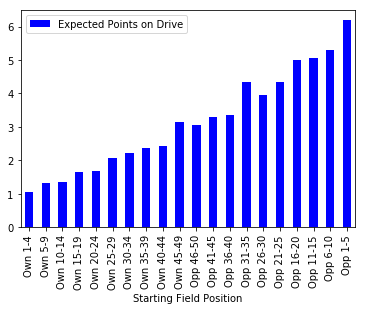

In [27]:
#Plot Expected points vs Yard Block
df_final.plot(x='Starting Field Position', y='Expected Points on Drive', kind='bar', color = 'blue')
plt.show

# Getting 4th down conversion % by yards to go

In [28]:
#read in data and parse dates, adjust other data types 
os.chdir('C:/Users/drew.malter/Documents/Internal/Personal/NFL')
df = pd.read_csv('pbp-2016-18.csv', parse_dates = ['GameDate'])

In [29]:
#Create a flag for 4th down success: 1 if successful 4th down, 0 if any other play
df['4thDownSuccess'] = np.where((df['Down'] == 4) & (df['DefenseTeam'] == df['DefenseTeam'].shift(-1)) 
                                & (df['Down'].shift(-1) == 1) & (df['PlayType'] != 'PUNT') 
                                & (df['PlayType'] != 'FIELD GOAL')
                                 & (df['PlayType'] != 'PENALTY')
                                 & (df['PlayType'] != 'NO PLAY')
                                 & (df['PlayType'] != 'EXCEPTION')
                                    & (df['PlayType'] != 'QB KNEEEL'), 1, 0)

In [30]:
#Create a flag for 4th down fail: 1 if successful 4th down, 0 if any other play
df['4thDownFail'] = np.where((df['Down'] == 4) & (df['DefenseTeam'] != df['DefenseTeam'].shift(-1)) 
                                & (df['Down'].shift(-1) == 1) & (df['PlayType'] != 'PUNT') 
                                & (df['PlayType'] != 'FIELD GOAL')
                                 & (df['PlayType'] != 'PENALTY')
                                 & (df['PlayType'] != 'NO PLAY')
                                 & (df['PlayType'] != 'EXCEPTION')
                                 & (df['PlayType'] != 'QB KNEEEL'), 1, 0)

In [31]:
#Cut the data set down to only 4th down conversion plays
df = df[(df['Down'] == 4) 
                                & (df['PlayType'] != 'PUNT') 
                                & (df['PlayType'] != 'FIELD GOAL')
                                & (df['PlayType'] != 'PENALTY')
                                & (df['PlayType'] != 'NO PLAY')
                                & (df['PlayType'] != 'EXCEPTION') ]

In [32]:
#Seperately for 4th downs within the 10 yard line
df_goal = df[(df['Down'] == 4) 
                                & (df['PlayType'] != 'PUNT') 
                                & (df['PlayType'] != 'FIELD GOAL')
                                & (df['PlayType'] != 'PENALTY')
                                & (df['PlayType'] != 'NO PLAY')
                                & (df['PlayType'] != 'EXCEPTION')
                                & (df['YardLine'] + df['ToGo'] == 100)]

In [33]:
df_goal.head()

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Unnamed: 10,SeriesFirstDown,Unnamed: 12,NextScore,Description,TeamWin,Unnamed: 16,Unnamed: 17,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,4thDownSuccess,4thDownFail
11,2018090600,2018-09-06,1,10,55,ATL,PHI,4,1,99,nan,0,nan,0,(10:55) 24-D.FREEMAN LEFT END TO PHI 2 FOR -1 ...,0,nan,nan,2018,-1,UNDER CENTER,RUSH,1,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,LEFT END,1,OPP,0,NaN,0,NaN,0,0,1
183,2018090600,2018-09-06,4,0,6,ATL,PHI,4,10,90,nan,0,nan,0,(:06) (SHOTGUN) 2-M.RYAN PASS INCOMPLETE SHORT...,0,nan,nan,2018,0,SHOTGUN,PASS,0,1,1,0,SHORT RIGHT,0,0,0,nan,0,0,0,1,0,0,NaN,10,OPP,1,PHI,1,ILLEGAL CONTACT,5,1,0
825,2018090903,2018-09-09,1,1,47,TEN,MIA,4,3,97,nan,0,nan,0,(1:47) (SHOTGUN) 8-M.MARIOTA PASS SHORT RIGHT ...,0,nan,nan,2018,1,SHOTGUN,PASS,0,1,0,0,SHORT RIGHT,0,0,0,nan,0,0,0,0,0,0,NaN,3,OPP,0,NaN,0,NaN,0,0,1
2060,2018090909,2018-09-09,4,3,26,ARI,WAS,4,7,93,nan,0,nan,0,(3:26) (SHOTGUN) 9-S.BRADFORD PASS INCOMPLETE ...,0,nan,nan,2018,0,SHOTGUN,PASS,0,1,1,0,SHORT RIGHT,0,0,0,nan,0,0,0,0,0,0,NaN,7,OPP,0,NaN,0,NaN,0,0,1
2782,2018091000,2018-09-10,4,0,38,NYJ,DET,4,12,88,nan,0,nan,0,(:38) 14-S.DARNOLD KNEELS TO DET 13 FOR -1 YARDS.,0,nan,nan,2018,0,UNDER CENTER,QB KNEEL,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,12,OPP,0,NaN,0,NaN,0,0,1


In [34]:
#Until I figure out why there are 0s in both columns at the same time, remove those
df = df[(df['4thDownSuccess'] == 1) | (df['4thDownFail'] == 1)]
#df_goal = df_goal[(df_goal['4thDownSuccess'] == 1) | (df_goal['4thDownFail'] == 1)]

In [35]:
df.head()

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Unnamed: 10,SeriesFirstDown,Unnamed: 12,NextScore,Description,TeamWin,Unnamed: 16,Unnamed: 17,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,4thDownSuccess,4thDownFail
11,2018090600,2018-09-06,1,10,55,ATL,PHI,4,1,99,nan,0,nan,0,(10:55) 24-D.FREEMAN LEFT END TO PHI 2 FOR -1 ...,0,nan,nan,2018,-1,UNDER CENTER,RUSH,1,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,LEFT END,1,OPP,0,NaN,0,NaN,0,0,1
183,2018090600,2018-09-06,4,0,6,ATL,PHI,4,10,90,nan,0,nan,0,(:06) (SHOTGUN) 2-M.RYAN PASS INCOMPLETE SHORT...,0,nan,nan,2018,0,SHOTGUN,PASS,0,1,1,0,SHORT RIGHT,0,0,0,nan,0,0,0,1,0,0,NaN,10,OPP,1,PHI,1,ILLEGAL CONTACT,5,1,0
539,2018090901,2018-09-09,4,7,49,CLE,PIT,4,5,82,nan,0,nan,0,(7:49) (SHOTGUN) 5-T.TAYLOR PASS INCOMPLETE DE...,0,nan,nan,2018,0,SHOTGUN,PASS,0,1,1,0,DEEP LEFT,0,0,0,nan,0,0,0,0,0,0,NaN,18,OPP,0,NaN,0,NaN,0,0,1
825,2018090903,2018-09-09,1,1,47,TEN,MIA,4,3,97,nan,0,nan,0,(1:47) (SHOTGUN) 8-M.MARIOTA PASS SHORT RIGHT ...,0,nan,nan,2018,1,SHOTGUN,PASS,0,1,0,0,SHORT RIGHT,0,0,0,nan,0,0,0,0,0,0,NaN,3,OPP,0,NaN,0,NaN,0,0,1
862,2018090903,2018-09-09,2,2,0,MIA,TEN,4,1,85,nan,0,nan,0,(2:00) 17-R.TANNEHILL PASS INCOMPLETE SHORT RI...,0,nan,nan,2018,0,UNDER CENTER,PASS,0,1,1,0,SHORT RIGHT,0,0,0,nan,0,0,0,0,0,0,NaN,15,OPP,0,NaN,0,NaN,0,0,1


In [36]:
#Group by Yards To Go and return avreage of success and fail
df1 = df.groupby(
   ['ToGo']
).agg(
    {
       
        '4thDownSuccess': 'mean' #
        ,'4thDownFail':'mean' #
        ,'Down': 'count'

    }
)
df1

,4thDownSuccess,4thDownFail,Down
ToGo,,,
1,0.62,0.38,476
2,0.51,0.49,136
3,0.45,0.55,108
4,0.45,0.55,87
5,0.39,0.61,72
6,0.39,0.61,70
7,0.49,0.51,45
8,0.29,0.71,21
9,0.23,0.77,31


In [37]:
#Remove 4th and over 10 because not enough data and re group
df = df[(df['ToGo'] <= 10)]

df1 = df.groupby(
   ['ToGo']
).agg(
    {
       
        '4thDownSuccess': 'mean' #
        ,'4thDownFail':'mean' #
        ,'Down': 'count'
        ,'ToGo': min

    }
)
df1 = df1.rename(columns={'Down': 'Count Of Attempts'})
df1 = df1.rename(columns={'4thDownSuccess': '4th Down Success Rate'})
df1 = df1.rename(columns={'4thDownFail': '4th Down Fail Rate'})
df1

,4th Down Success Rate,4th Down Fail Rate,Count Of Attempts,ToGo
ToGo,,,,
1,0.62,0.38,476,1
2,0.51,0.49,136,2
3,0.45,0.55,108,3
4,0.45,0.55,87,4
5,0.39,0.61,72,5
6,0.39,0.61,70,6
7,0.49,0.51,45,7
8,0.29,0.71,21,8
9,0.23,0.77,31,9


In [38]:
#Remove 4th and over 10 because not enough data and re group
df_goal = df_goal[(df_goal['ToGo'] <= 10)]

df2 = df_goal.groupby(
   ['ToGo']
).agg(
    {
       
        'IsTouchdown': 'mean' #
        ,'Down': 'count'
        ,'ToGo': min

    }
)
df2 = df2.rename(columns={'Down': 'Count Of Attempts'})
df2 = df2.rename(columns={'IsTouchdown': '4th and Goal Success Rate'})
df2

,4th and Goal Success Rate,Count Of Attempts,ToGo
ToGo,,,
1,0.54,95,1
2,0.67,15,2
3,0.60,10,3
4,0.60,5,4
5,0.20,5,5
6,0.60,5,6
7,0.57,7,7
10,0.33,3,10


<function matplotlib.pyplot.show(*args, **kw)>

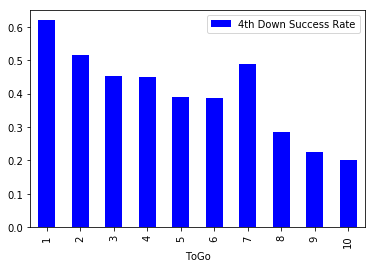

In [39]:
#Plot Success Rate vs ToGo
df1.plot(x='ToGo', y='4th Down Success Rate', kind='bar', color = 'blue')
plt.show

# Look into punt distances by yard line

In [40]:
#read in data and parse dates, adjust other data types 
os.chdir('C:/Users/drew.malter/Documents/Internal/Personal/NFL')
df = pd.read_csv('pbp-2016-18.csv', parse_dates = ['GameDate'])

In [41]:
# Remove plays where yardline = 0
#These are two minute warnings, time outs, extra points, , etc. and we wont use them
#However we need to keep kick offs because they'll help us define the first possession of every half
#If down is 0 and yarline is 35 then we keep it. 
df = df[(df.Down != 0) | ((df.Down == 0) & (df.YardLine == 35))]
df.shape

(121887, 45)

In [42]:
#Sort data by gameID, quarter, minute, second, down (Minute and Second sort large to small)
df = df.sort_values(['GameId', 'Quarter', 'Minute', 'Second', 'Down'], ascending=[False, True, False, False, True]).reset_index()
df.head(50)

,index,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Unnamed: 10,SeriesFirstDown,Unnamed: 12,NextScore,Description,TeamWin,Unnamed: 16,Unnamed: 17,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards
0,44840,2018123015,2018-12-30,1,15,0,SEA,ARI,0,0,35,nan,1,nan,0,11-S.JANIKOWSKI KICKS 65 YARDS FROM SEA 35 TO ...,0,nan,nan,2018,0,UNDER CENTER,KICK OFF,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,35,OWN,0,NaN,0,NaN,0
1,44841,2018123015,2018-12-30,1,15,0,ARI,SEA,1,10,25,nan,0,nan,0,(15:00) 3-J.ROSEN PASS INCOMPLETE DEEP RIGHT T...,0,nan,nan,2018,0,UNDER CENTER,PASS,0,1,1,0,DEEP RIGHT,0,0,0,nan,0,0,0,0,0,0,NaN,25,OWN,0,NaN,0,NaN,0
2,44842,2018123015,2018-12-30,1,14,53,ARI,SEA,2,10,25,nan,0,nan,0,(14:53) (SHOTGUN) 31-D.JOHNSON LEFT TACKLE TO ...,0,nan,nan,2018,9,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,LEFT TACKLE,25,OWN,0,NaN,0,NaN,0
3,44843,2018123015,2018-12-30,1,14,16,ARI,SEA,3,1,34,nan,0,nan,0,(14:16) 31-D.JOHNSON RIGHT GUARD TO ARI 34 FOR...,0,nan,nan,2018,0,UNDER CENTER,RUSH,1,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,RIGHT GUARD,34,OWN,0,NaN,0,NaN,0
4,44844,2018123015,2018-12-30,1,13,34,ARI,SEA,4,1,34,nan,0,nan,0,"(13:34) 2-A.LEE PUNTS 47 YARDS TO SEA 19, CENT...",0,nan,nan,2018,0,PUNT,PUNT,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,34,OWN,0,NaN,0,NaN,0
5,44845,2018123015,2018-12-30,1,13,28,SEA,ARI,1,10,19,nan,0,nan,0,(13:28) (SHOTGUN) 53-J.HUNT REPORTED IN AS ELI...,0,nan,nan,2018,5,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,CENTER,19,OWN,0,NaN,0,NaN,0
6,44846,2018123015,2018-12-30,1,12,57,SEA,ARI,2,5,24,nan,1,nan,0,(12:57) (SHOTGUN) 32-C.CARSON RIGHT TACKLE TO ...,0,nan,nan,2018,8,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,RIGHT TACKLE,24,OWN,0,NaN,0,NaN,0
7,44847,2018123015,2018-12-30,1,12,21,SEA,ARI,1,10,32,nan,0,nan,0,(12:21) (SHOTGUN) 27-M.DAVIS UP THE MIDDLE TO ...,0,nan,nan,2018,3,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,CENTER,32,OWN,0,NaN,0,NaN,0
8,44848,2018123015,2018-12-30,1,11,43,SEA,ARI,2,7,35,nan,0,nan,0,(11:43) 3-R.WILSON PASS INCOMPLETE DEEP RIGHT.,0,nan,nan,2018,0,UNDER CENTER,PASS,0,1,1,0,DEEP RIGHT,0,0,0,nan,0,0,0,0,0,0,NaN,35,OWN,0,NaN,0,NaN,0
9,44849,2018123015,2018-12-30,1,11,36,SEA,ARI,3,7,35,nan,1,nan,0,(11:36) (SHOTGUN) 84-E.DICKSON LEFT END TO SEA...,0,nan,nan,2018,9,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,LEFT END,35,OWN,0,NaN,0,NaN,0


In [43]:
#Create column PuntDistance.  Next step will be remove all non punts so doesn't matter if we populate 
#non punts with wrong data

#Punt distnace will include returns (because that's what really matters. 100 - starting yardline minus ending yardline)

df['PuntDistance'] = 100 - df['YardLine'] - df['YardLine'].shift(-1)
df.head(30)

,index,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Unnamed: 10,SeriesFirstDown,Unnamed: 12,NextScore,Description,TeamWin,Unnamed: 16,Unnamed: 17,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,PuntDistance
0,44840,2018123015,2018-12-30,1,15,0,SEA,ARI,0,0,35,nan,1,nan,0,11-S.JANIKOWSKI KICKS 65 YARDS FROM SEA 35 TO ...,0,nan,nan,2018,0,UNDER CENTER,KICK OFF,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,35,OWN,0,NaN,0,NaN,0,40.00
1,44841,2018123015,2018-12-30,1,15,0,ARI,SEA,1,10,25,nan,0,nan,0,(15:00) 3-J.ROSEN PASS INCOMPLETE DEEP RIGHT T...,0,nan,nan,2018,0,UNDER CENTER,PASS,0,1,1,0,DEEP RIGHT,0,0,0,nan,0,0,0,0,0,0,NaN,25,OWN,0,NaN,0,NaN,0,50.00
2,44842,2018123015,2018-12-30,1,14,53,ARI,SEA,2,10,25,nan,0,nan,0,(14:53) (SHOTGUN) 31-D.JOHNSON LEFT TACKLE TO ...,0,nan,nan,2018,9,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,LEFT TACKLE,25,OWN,0,NaN,0,NaN,0,41.00
3,44843,2018123015,2018-12-30,1,14,16,ARI,SEA,3,1,34,nan,0,nan,0,(14:16) 31-D.JOHNSON RIGHT GUARD TO ARI 34 FOR...,0,nan,nan,2018,0,UNDER CENTER,RUSH,1,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,RIGHT GUARD,34,OWN,0,NaN,0,NaN,0,32.00
4,44844,2018123015,2018-12-30,1,13,34,ARI,SEA,4,1,34,nan,0,nan,0,"(13:34) 2-A.LEE PUNTS 47 YARDS TO SEA 19, CENT...",0,nan,nan,2018,0,PUNT,PUNT,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,34,OWN,0,NaN,0,NaN,0,47.00
5,44845,2018123015,2018-12-30,1,13,28,SEA,ARI,1,10,19,nan,0,nan,0,(13:28) (SHOTGUN) 53-J.HUNT REPORTED IN AS ELI...,0,nan,nan,2018,5,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,CENTER,19,OWN,0,NaN,0,NaN,0,57.00
6,44846,2018123015,2018-12-30,1,12,57,SEA,ARI,2,5,24,nan,1,nan,0,(12:57) (SHOTGUN) 32-C.CARSON RIGHT TACKLE TO ...,0,nan,nan,2018,8,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,RIGHT TACKLE,24,OWN,0,NaN,0,NaN,0,44.00
7,44847,2018123015,2018-12-30,1,12,21,SEA,ARI,1,10,32,nan,0,nan,0,(12:21) (SHOTGUN) 27-M.DAVIS UP THE MIDDLE TO ...,0,nan,nan,2018,3,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,CENTER,32,OWN,0,NaN,0,NaN,0,33.00
8,44848,2018123015,2018-12-30,1,11,43,SEA,ARI,2,7,35,nan,0,nan,0,(11:43) 3-R.WILSON PASS INCOMPLETE DEEP RIGHT.,0,nan,nan,2018,0,UNDER CENTER,PASS,0,1,1,0,DEEP RIGHT,0,0,0,nan,0,0,0,0,0,0,NaN,35,OWN,0,NaN,0,NaN,0,30.00
9,44849,2018123015,2018-12-30,1,11,36,SEA,ARI,3,7,35,nan,1,nan,0,(11:36) (SHOTGUN) 84-E.DICKSON LEFT END TO SEA...,0,nan,nan,2018,9,SHOTGUN,RUSH,1,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,LEFT END,35,OWN,0,NaN,0,NaN,0,21.00


In [44]:
#Filter df for punts only

#Blocks are not currently accounted for 
df = df[(df['PlayType'] == 'PUNT') & (df['IsNoPlay'] == 0)]
df.head(2000)

,index,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Unnamed: 10,SeriesFirstDown,Unnamed: 12,NextScore,Description,TeamWin,Unnamed: 16,Unnamed: 17,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,PuntDistance
4,44844,2018123015,2018-12-30,1,13,34,ARI,SEA,4,1,34,nan,0,nan,0,"(13:34) 2-A.LEE PUNTS 47 YARDS TO SEA 19, CENT...",0,nan,nan,2018,0,PUNT,PUNT,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,34,OWN,0,NaN,0,NaN,0,47.00
24,44864,2018123015,2018-12-30,1,5,35,SEA,ARI,4,14,20,nan,0,nan,0,"(5:35) 4-M.DICKSON PUNTS 46 YARDS TO ARI 34, C...",0,nan,nan,2018,0,PUNT,PUNT,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,20,OWN,0,NaN,0,NaN,0,41.00
53,44897,2018123015,2018-12-30,2,9,20,ARI,SEA,4,9,45,nan,0,nan,0,"(9:20) 2-A.LEE PUNTS 42 YARDS TO SEA 13, CENTE...",0,nan,nan,2018,0,PUNT,PUNT,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,45,OWN,0,NaN,0,NaN,0,42.00
57,44901,2018123015,2018-12-30,2,7,20,SEA,ARI,4,17,6,nan,0,nan,0,"(7:20) 4-M.DICKSON PUNTS 21 YARDS TO SEA 27, C...",0,nan,nan,2018,0,PUNT,PUNT,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,6,OWN,0,NaN,0,NaN,0,21.00
65,44910,2018123015,2018-12-30,2,3,43,SEA,ARI,4,14,12,nan,0,nan,0,"(3:43) 4-M.DICKSON PUNTS 54 YARDS TO ARI 34, C...",0,nan,nan,2018,0,PUNT,PUNT,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,12,OWN,0,NaN,0,NaN,0,9.00
74,44921,2018123015,2018-12-30,2,0,57,SEA,ARI,4,10,25,nan,0,nan,0,"(:57) 4-M.DICKSON PUNTS 42 YARDS TO ARI 33, CE...",0,nan,nan,2018,0,PUNT,PUNT,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,25,OWN,0,NaN,0,NaN,0,39.00
85,44934,2018123015,2018-12-30,3,13,54,SEA,ARI,4,4,31,nan,0,nan,0,"(13:54) 4-M.DICKSON PUNTS 44 YARDS TO ARI 25, ...",0,nan,nan,2018,0,PUNT,PUNT,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,31,OWN,0,NaN,0,NaN,0,50.00
90,44939,2018123015,2018-12-30,3,11,50,ARI,SEA,4,2,27,nan,0,nan,0,"(11:50) 2-A.LEE PUNTS 50 YARDS TO SEA 23, CENT...",0,nan,nan,2018,0,PUNT,PUNT,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,27,OWN,0,NaN,0,NaN,0,50.00
94,44943,2018123015,2018-12-30,3,10,47,SEA,ARI,4,18,15,nan,0,nan,0,"(10:47) 4-M.DICKSON PUNTS 60 YARDS TO ARI 25, ...",0,nan,nan,2018,0,PUNT,PUNT,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,15,OWN,0,NaN,0,NaN,0,46.00
100,44949,2018123015,2018-12-30,3,7,38,ARI,SEA,4,13,52,nan,0,nan,0,"(7:38) 2-A.LEE PUNTS 46 YARDS TO SEA 2, CENTER...",0,nan,nan,2018,0,PUNT,PUNT,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,48,OPP,0,NaN,0,NaN,0,46.00


In [45]:
df.shape

(7009, 47)

In [46]:
#Block yard lines into groups of 5
df['YardBlock'] = (df['YardLine'] // 5)

In [47]:
#Rename the YardBlocks
df.reset_index(level=0, inplace=True)

df['Starting Field Position'] = 'Hi'
df.loc[df.YardBlock ==  0, 'Starting Field Position'] = 'Own 1-4'
df.loc[df.YardBlock ==  1, 'Starting Field Position'] = 'Own 5-9'
df.loc[df.YardBlock ==  2, 'Starting Field Position'] = 'Own 10-14'
df.loc[df.YardBlock ==  3, 'Starting Field Position'] = 'Own 15-19'
df.loc[df.YardBlock ==  4, 'Starting Field Position'] = 'Own 20-24'
df.loc[df.YardBlock ==  5, 'Starting Field Position'] = 'Own 25-29'
df.loc[df.YardBlock ==  6, 'Starting Field Position'] = 'Own 30-34'
df.loc[df.YardBlock ==  7, 'Starting Field Position'] = 'Own 35-39'
df.loc[df.YardBlock ==  8, 'Starting Field Position'] = 'Own 40-44'
df.loc[df.YardBlock ==  9, 'Starting Field Position'] = 'Own 45-49'
df.loc[df.YardBlock ==  10, 'Starting Field Position'] = 'Opp 46-50'
df.loc[df.YardBlock ==  11, 'Starting Field Position'] = 'Opp 41-45'
df.loc[df.YardBlock ==  12, 'Starting Field Position'] = 'Opp 36-40'
df.loc[df.YardBlock ==  13, 'Starting Field Position'] = 'Opp 31-35'
df.loc[df.YardBlock ==  14, 'Starting Field Position'] = 'Opp 26-30'
df.loc[df.YardBlock ==  15, 'Starting Field Position'] = 'Opp 21-25'
df.loc[df.YardBlock ==  16, 'Starting Field Position'] = 'Opp 16-20'
df.loc[df.YardBlock ==  17, 'Starting Field Position'] = 'Opp 11-15'
df.loc[df.YardBlock ==  18, 'Starting Field Position'] = 'Opp 6-10'
df.loc[df.YardBlock ==  19, 'Starting Field Position'] = 'Opp 1-6'

df.head()

,level_0,index,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Unnamed: 10,SeriesFirstDown,Unnamed: 12,NextScore,Description,TeamWin,Unnamed: 16,Unnamed: 17,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,PuntDistance,YardBlock,Starting Field Position
0,4,44844,2018123015,2018-12-30,1,13,34,ARI,SEA,4,1,34,nan,0,nan,0,"(13:34) 2-A.LEE PUNTS 47 YARDS TO SEA 19, CENT...",0,nan,nan,2018,0,PUNT,PUNT,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,34,OWN,0,NaN,0,NaN,0,47.00,6,Own 30-34
1,24,44864,2018123015,2018-12-30,1,5,35,SEA,ARI,4,14,20,nan,0,nan,0,"(5:35) 4-M.DICKSON PUNTS 46 YARDS TO ARI 34, C...",0,nan,nan,2018,0,PUNT,PUNT,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,20,OWN,0,NaN,0,NaN,0,41.00,4,Own 20-24
2,53,44897,2018123015,2018-12-30,2,9,20,ARI,SEA,4,9,45,nan,0,nan,0,"(9:20) 2-A.LEE PUNTS 42 YARDS TO SEA 13, CENTE...",0,nan,nan,2018,0,PUNT,PUNT,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,45,OWN,0,NaN,0,NaN,0,42.00,9,Own 45-49
3,57,44901,2018123015,2018-12-30,2,7,20,SEA,ARI,4,17,6,nan,0,nan,0,"(7:20) 4-M.DICKSON PUNTS 21 YARDS TO SEA 27, C...",0,nan,nan,2018,0,PUNT,PUNT,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,6,OWN,0,NaN,0,NaN,0,21.00,1,Own 5-9
4,65,44910,2018123015,2018-12-30,2,3,43,SEA,ARI,4,14,12,nan,0,nan,0,"(3:43) 4-M.DICKSON PUNTS 54 YARDS TO ARI 34, C...",0,nan,nan,2018,0,PUNT,PUNT,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,12,OWN,0,NaN,0,NaN,0,9.00,2,Own 10-14


In [48]:
#Group by starting field position and return the mean of Points, Number of plays, and percentages of OffensiveTDs and Field Goals
df_final = df.groupby(
   ['YardBlock']
).agg(
    {
       
        'Starting Field Position': min
        ,'PuntDistance': 'mean' #Expected points scored on that drive
        #,'IsOffensiveTD':'mean' #Percent of drives that result in an offensive TD
        #,'IsFieldGoal': 'mean' #Percent of drives that result in a field goal
       # ,'NumberOfPlays': 'mean'
       # ,'YardBlock' : 'count' #count if drives per yard block
    }
)

#Rename and reformat columns for presentation
#df_final['IsOffensiveTD'] = (100. * df_final['IsOffensiveTD']).round(2).astype(str) + '%'
#df_final['IsFieldGoal'] = (100. * df_final['IsFieldGoal']).round(2).astype(str) + '%'
#df_final = df_final.rename(columns={'YardBlock': 'Count Of Drives'})
#df_final = df_final.rename(columns={'NumberOfPlays': 'Avg Plays per Drive'})
#df_final = df_final.rename(columns={'IsFieldGoal': '% Chance of FG'})
#df_final = df_final.rename(columns={'IsOffensiveTD': '% Chance of TD'})
df_final = df_final.rename(columns={'PuntDistance': 'Punt Distance'})
df_final

,Starting Field Position,Punt Distance
YardBlock,,
0,Own 1-4,43.94
1,Own 5-9,43.90
2,Own 10-14,43.70
3,Own 15-19,44.08
4,Own 20-24,43.89
5,Own 25-29,43.36
6,Own 30-34,42.62
7,Own 35-39,41.87
8,Own 40-44,40.43


<function matplotlib.pyplot.show(*args, **kw)>

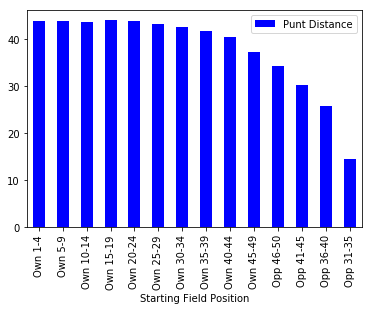

In [49]:
#Plot PuntDistance vs field position
df_final.plot(x='Starting Field Position', y='Punt Distance', kind='bar', color = 'blue')
plt.show

# Field Goal Percentage by yardline

In [50]:
#read in data and parse dates, adjust other data types 
os.chdir('C:/Users/drew.malter/Documents/Internal/Personal/NFL')
df = pd.read_csv('pbp-2016-18.csv', parse_dates = ['GameDate'])

In [51]:
#Create flag for
#Field Goal if description contains 'Field Goal is Good'

df['IsFieldGoal'] = np.where(df['Description'].str.contains('Field Goal is Good', case=False, na=False), 1, 0) 

In [52]:
#Filter df for FGs only

df = df[(df['PlayType'] == 'FIELD GOAL') & (df['IsNoPlay'] == 0)]
df.head()

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Unnamed: 10,SeriesFirstDown,Unnamed: 12,NextScore,Description,TeamWin,Unnamed: 16,Unnamed: 17,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,IsFieldGoal
25,2018090600,2018-09-06,1,5,3,ATL,PHI,4,3,97,nan,0,nan,0,"(5:03) 3-M.BRYANT 21 YARD FIELD GOAL IS GOOD, ...",0,nan,nan,2018,0,FIELD GOAL,FIELD GOAL,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,3,OPP,0,NaN,0,NaN,0,1
55,2018090600,2018-09-06,2,6,12,PHI,ATL,4,8,92,nan,0,nan,0,"(6:12) 4-J.ELLIOTT 26 YARD FIELD GOAL IS GOOD,...",0,nan,nan,2018,0,FIELD GOAL,FIELD GOAL,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,8,OPP,0,NaN,0,NaN,0,1
65,2018090600,2018-09-06,2,2,13,ATL,PHI,4,17,66,nan,0,nan,0,"(2:13) 3-M.BRYANT 52 YARD FIELD GOAL IS GOOD, ...",0,nan,nan,2018,0,FIELD GOAL,FIELD GOAL,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,34,OPP,0,NaN,0,NaN,0,1
236,2018090900,2018-09-09,2,13,18,BAL,BUF,4,13,77,nan,0,nan,0,(13:18) (FIELD GOAL FORMATION) 9-J.TUCKER 41 Y...,0,nan,nan,2018,0,FIELD GOAL,FIELD GOAL,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,23,OPP,0,NaN,0,NaN,0,1
252,2018090900,2018-09-09,2,8,48,BUF,BAL,4,9,66,nan,0,nan,0,(8:48) (FIELD GOAL FORMATION) 4-S.HAUSCHKA 52 ...,0,nan,nan,2018,0,FIELD GOAL,FIELD GOAL,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,34,OPP,0,NaN,0,NaN,0,0


In [53]:
#Block yard lines into groups of 5
df['YardBlock'] = (df['YardLine'] // 5)

In [54]:
#Rename the YardBlocks
df.reset_index(level=0, inplace=True)

df['Starting Field Position'] = 'Hi'
df.loc[df.YardBlock ==  0, 'Starting Field Position'] = 'Own 1-4'
df.loc[df.YardBlock ==  1, 'Starting Field Position'] = 'Own 5-9'
df.loc[df.YardBlock ==  2, 'Starting Field Position'] = 'Own 10-14'
df.loc[df.YardBlock ==  3, 'Starting Field Position'] = 'Own 15-19'
df.loc[df.YardBlock ==  4, 'Starting Field Position'] = 'Own 20-24'
df.loc[df.YardBlock ==  5, 'Starting Field Position'] = 'Own 25-29'
df.loc[df.YardBlock ==  6, 'Starting Field Position'] = 'Own 30-34'
df.loc[df.YardBlock ==  7, 'Starting Field Position'] = 'Own 35-39'
df.loc[df.YardBlock ==  8, 'Starting Field Position'] = 'Own 40-44'
df.loc[df.YardBlock ==  9, 'Starting Field Position'] = 'Own 45-49'
df.loc[df.YardBlock ==  10, 'Starting Field Position'] = 'Opp 46-50'
df.loc[df.YardBlock ==  11, 'Starting Field Position'] = 'Opp 41-45'
df.loc[df.YardBlock ==  12, 'Starting Field Position'] = 'Opp 36-40'
df.loc[df.YardBlock ==  13, 'Starting Field Position'] = 'Opp 31-35'
df.loc[df.YardBlock ==  14, 'Starting Field Position'] = 'Opp 26-30'
df.loc[df.YardBlock ==  15, 'Starting Field Position'] = 'Opp 21-25'
df.loc[df.YardBlock ==  16, 'Starting Field Position'] = 'Opp 16-20'
df.loc[df.YardBlock ==  17, 'Starting Field Position'] = 'Opp 11-15'
df.loc[df.YardBlock ==  18, 'Starting Field Position'] = 'Opp 6-10'
df.loc[df.YardBlock ==  19, 'Starting Field Position'] = 'Opp 1-6'

df.head()

,index,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Unnamed: 10,SeriesFirstDown,Unnamed: 12,NextScore,Description,TeamWin,Unnamed: 16,Unnamed: 17,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,Challenger,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,IsFieldGoal,YardBlock,Starting Field Position
0,25,2018090600,2018-09-06,1,5,3,ATL,PHI,4,3,97,nan,0,nan,0,"(5:03) 3-M.BRYANT 21 YARD FIELD GOAL IS GOOD, ...",0,nan,nan,2018,0,FIELD GOAL,FIELD GOAL,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,3,OPP,0,NaN,0,NaN,0,1,19,Opp 1-6
1,55,2018090600,2018-09-06,2,6,12,PHI,ATL,4,8,92,nan,0,nan,0,"(6:12) 4-J.ELLIOTT 26 YARD FIELD GOAL IS GOOD,...",0,nan,nan,2018,0,FIELD GOAL,FIELD GOAL,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,8,OPP,0,NaN,0,NaN,0,1,18,Opp 6-10
2,65,2018090600,2018-09-06,2,2,13,ATL,PHI,4,17,66,nan,0,nan,0,"(2:13) 3-M.BRYANT 52 YARD FIELD GOAL IS GOOD, ...",0,nan,nan,2018,0,FIELD GOAL,FIELD GOAL,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,34,OPP,0,NaN,0,NaN,0,1,13,Opp 31-35
3,236,2018090900,2018-09-09,2,13,18,BAL,BUF,4,13,77,nan,0,nan,0,(13:18) (FIELD GOAL FORMATION) 9-J.TUCKER 41 Y...,0,nan,nan,2018,0,FIELD GOAL,FIELD GOAL,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,23,OPP,0,NaN,0,NaN,0,1,15,Opp 21-25
4,252,2018090900,2018-09-09,2,8,48,BUF,BAL,4,9,66,nan,0,nan,0,(8:48) (FIELD GOAL FORMATION) 4-S.HAUSCHKA 52 ...,0,nan,nan,2018,0,FIELD GOAL,FIELD GOAL,0,0,0,0,NaN,0,0,0,nan,0,0,0,0,0,0,NaN,34,OPP,0,NaN,0,NaN,0,0,13,Opp 31-35


In [55]:
#Group by starting field position and return the mean of Points, Number of plays, and percentages of OffensiveTDs and Field Goals
df_final = df.groupby(
   ['YardBlock']
).agg(
    {
       
        'Starting Field Position': min
        ,'IsFieldGoal': 'mean' #Expected points scored on that drive
        #,'IsOffensiveTD':'mean' #Percent of drives that result in an offensive TD
        #,'IsFieldGoal': 'mean' #Percent of drives that result in a field goal
       # ,'NumberOfPlays': 'mean'
       # ,'YardBlock' : 'count' #count if drives per yard block
    }
)

#Rename and reformat columns for presentation
#df_final['IsOffensiveTD'] = (100. * df_final['IsOffensiveTD']).round(2).astype(str) + '%'
#df_final['IsFieldGoal'] = (100. * df_final['IsFieldGoal']).round(2).astype(str) + '%'
#df_final = df_final.rename(columns={'YardBlock': 'Count Of Drives'})
#df_final = df_final.rename(columns={'NumberOfPlays': 'Avg Plays per Drive'})
df_final = df_final.rename(columns={'IsFieldGoal': '% FG Made'})
#df_final = df_final.rename(columns={'IsOffensiveTD': '% Chance of TD'})
#df_final = df_final.rename(columns={'Points': 'Expected Points on Drive'})
df_final

,Starting Field Position,% FG Made
YardBlock,,
11,Opp 41-45,0.41
12,Opp 36-40,0.56
13,Opp 31-35,0.71
14,Opp 26-30,0.74
15,Opp 21-25,0.85
16,Opp 16-20,0.88
17,Opp 11-15,0.96
18,Opp 6-10,0.97
19,Opp 1-6,0.99


<function matplotlib.pyplot.show(*args, **kw)>

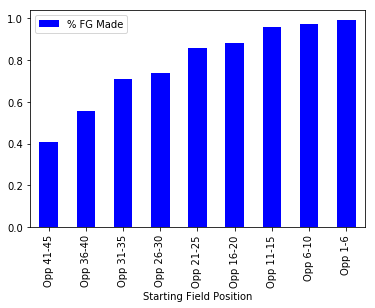

In [56]:
#Plot Field Goal Percentage vs field position
df_final.plot(x='Starting Field Position', y='% FG Made', kind='bar', color = 'blue')
plt.show